<a href="https://colab.research.google.com/github/emilianodesu/SIAFI-2026-1/blob/main/IDS/1_4_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction to Data Science

## 1.4 Dimensionality Reduction

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### 1.4.1 The Curse of Dimensionality

We are so used to living in three dimensions⁠1 that our intuition fails us when we try to imagine a high-dimensional space. Even a basic 4D hypercube is incredibly hard to picture in our minds, let alone a 200-dimensional ellipsoid bent in a 1,000-dimensional space.

![Point, segment, square, cube, and tesseract (0D to 4D hypercubes)](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/IDS/im/1_4/hmls_0701.png?raw=1)

As a result, high-dimensional datasets are often very sparse: most training instances are likely to be far away from each other, so training methods based on distance or similarity (such as k-nearest neighbors) will be much less effective. And some types of models will not be usable at all because they scale poorly with the dataset’s dimensionality (e.g., SVMs or dense neural networks). And new instances will likely be far away from any training instance, making predictions much less reliable than in lower dimensions since they will be based on much larger extrapolations. Since patterns in the data will become harder to identify, models will tend to fit the noise more frequently than in lower dimensions; regularization will become all the more important. Lastly, models will become even harder to interpret.

In theory, some of these issues can be resolved by increasing the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions. With just 100 features, all ranging from 0 to 1, you would need more training instances than atoms in the observable universe in order for training instances to be within 0.1 of each other on average, assuming they were spread out uniformly across all dimensions.

In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated (as discussed earlier for MNIST). As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space.

In [ ]:
# extra code

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
rng = np.random.default_rng(seed=42)
angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * rng.standard_normal((m, 3))  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

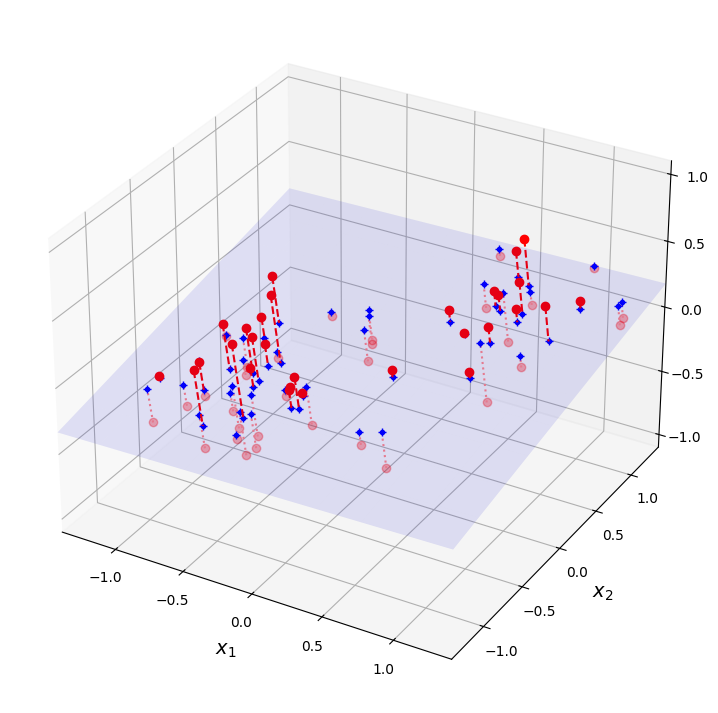

In [ ]:
# extra code

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])


plt.show()

Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the higher-dimensional (3D) space. If we project every training instance perpendicularly onto this subspace (as represented by the short dashed lines connecting the instances to the plane), we get a new 2D dataset. Ta-da! We have just reduced the dataset’s dimensionality from 3D to 2D. Note that the axes correspond to new features $z_1$ and $z_2$: they are the coordinates of the projections on the plane.

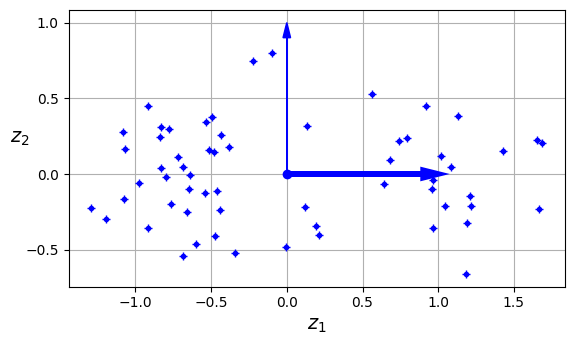

In [ ]:
# extra code

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)

### 1.4.2 Unsupervised dimensionality reduction: Principal Component Analysis (PCA)

Principal component analysis (PCA) is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it. PCA (*Principal Component Analysis*) is a feature *extraction* algorithm. The main difference is that in a selection algorithm, the original features are *preserved*, whereas in an extraction algorithm, the data is transformed or projected onto a new feature space.

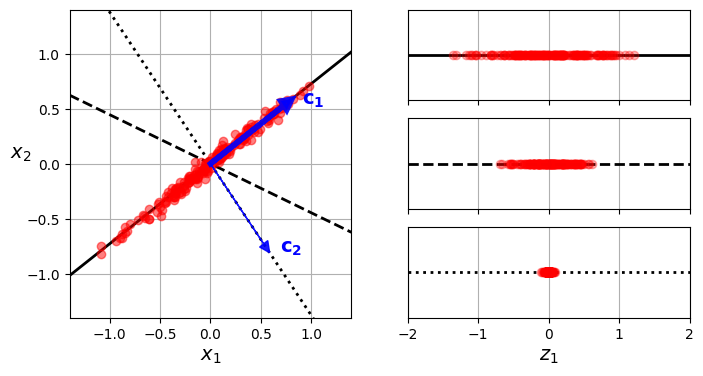

In [ ]:
# extra code

angle = np.pi / 5
stretch = 5
m = 200

rng = np.random.default_rng(seed=3)
X_line = rng.standard_normal((m, 2)) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()


plt.show()

PCA helps to identify patterns in data based on the correlation between features; that is, it attempts to find the directions of maximum variance in high-dimensional data and projects it onto a new subspace with an equal or smaller number of dimensions than the original. The algorithm consists of the following steps:

---

**Algorithm 1.1 *Principal Component Analysis***

1.  Standardize the $d$-dimensional dataset.
2.  Obtain the covariance matrix.
3.  Decompose the covariance matrix into its eigenvalues and eigenvectors.
4.  Sort the eigenvalues in descending order along with their corresponding eigenvectors.
5.  Select the $k$ eigenvectors that correspond to the $k$ largest eigenvalues; $k$ is the dimension of the new feature subspace ($k < d$).
6.  Construct a projection matrix $\mathbf{W}$ from the top $k$ eigenvectors.
7.  Transform the $d$-dimensional input dataset $\mathbf{X}$ using the projection matrix $\mathbf{W}$ to obtain the new $k$-dimensional feature subspace.

PCA identifies the axis that accounts for the largest amount of variance in the training set. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of the remaining variance. In this 2D example there is no choice: it is the dotted line. If it were a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on—as many axes as the number of dimensions in the dataset.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

After fitting the PCA transformer to the dataset, its `components_` attribute holds the transpose of $\mathbf{W_d}$: it contains one row for each of the first $d$ principal components.

In [ ]:
pca.components_

array([[ 0.66824153,  0.73208333,  0.13231495],
       [ 0.74374636, -0.66151587, -0.09611511]])

Another useful piece of information is the explained variance ratio of each principal component, available via the `explained_variance_ratio_` variable. The ratio indicates the proportion of the dataset’s variance that lies along each principal component. For example, let’s look at the explained variance ratios of the first two components of the 3D dataset

In [ ]:
pca.explained_variance_ratio_

array([0.82279334, 0.10821224])

This output tells us that about 82% of the dataset’s variance lies along the first PC, and about 11% lies along the second PC. This leaves about 7% for the third PC, so it is reasonable to assume that the third PC probably carries little information.

### 1.4.3 Choosing the Right number of Dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance—say, 95%. (An exception to this rule, of course, is if you are reducing dimensionality for data visualization, in which case you will want to reduce the dimensionality down to 2 or 3.)

The following code loads and splits the MNIST dataset and performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set’s variance:

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

In [ ]:
print(f"Number of dimensions to preserve 95% of the variance: {d}")

Number of dimensions to preserve 95% of the variance: 154


You could then set `n_components=d` and run PCA again, but there’s a better option. Instead of specifying the number of principal components you want to preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

np.int64(154)

In [ ]:
pca.explained_variance_ratio_.sum()

np.float64(0.9501960192613034)

Yet another option is to plot the explained variance as a function of the number of dimensions (simply plot cumsum). There will usually be an elbow in the curve, where the explained variance stops growing fast. In this case, you can see that reducing the dimensionality down to about 100 dimensions wouldn’t lose too much explained variance.

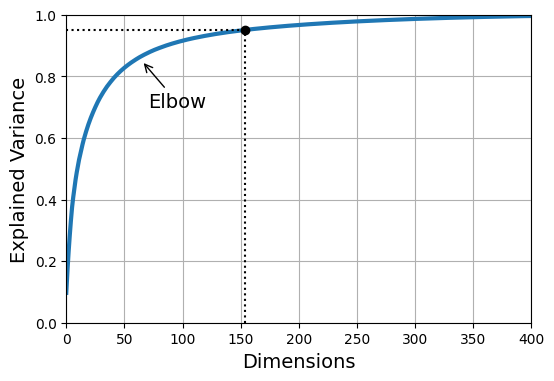

In [ ]:
# extra code

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)

plt.show()

Alternatively, if you are using dimensionality reduction as a preprocessing step for a supervised learning task (e.g., classification), then you can tune the number of dimensions as you would any other hyperparameter. For example, the following code example creates a two-step pipeline, first reducing dimensionality using PCA, then classifying using a random forest. Next, it uses `RandomizedSearchCV` to find a good combination of hyperparameters for both PCA and the random forest classifier. This example does a quick search, tuning only 2 hyperparameters, training on just 1,000 instances, and running for just 10 iterations, but feel free to do a more thorough search if you have the time:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'pca__n_components': array([10, 11... 78, 79]), 'randomforestclassifier__n_estimators': array([ 50, ...97, 498, 499])}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
rnd_search.best_params_

{'randomforestclassifier__n_estimators': np.int64(475),
 'pca__n_components': np.int64(57)}

It’s interesting to note how low the optimal number of components is: we reduced a 784-dimensional dataset to just 57 dimensions! This is tied to the fact that we used a random forest, which is a pretty powerful model. If we used a linear model instead, such as an `SGDClassifier`, the search would find that we need to preserve more dimensions (about 70).

### 1.4.4 PCA for Compression

After dimensionality reduction, the training set takes up much less space. For example, after applying PCA to the MNIST dataset while preserving 95% of its variance, we are left with 154 features, instead of the original 784 features. So the dataset is now less than 20% of its original size, and we only lost 5% of its variance! This is a reasonable compression ratio, and it’s easy to see how such a size reduction would speed up a classification algorithm tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. This won’t give you back the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be close to the original data. The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the reconstruction error.

The `inverse_transform()` method lets us decompress the reduced MNIST dataset back to 784 dimensions:

In [ ]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [ ]:
X_recovered = pca.inverse_transform(X_reduced)

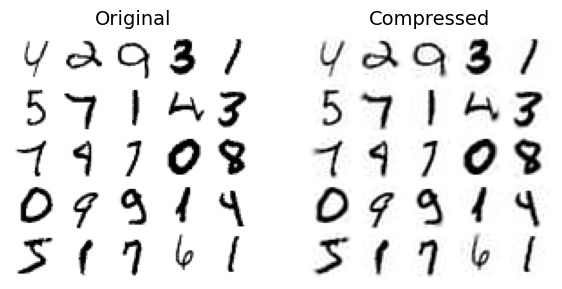

In [ ]:
# extra code

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

### 1.4.5 Supervised dimensionality reduction: Linear Discriminant Analysis (LDA)

Linear discriminant analysis (LDA) is a linear classification algorithm that, during training, learns the most discriminative axes between the classes. These axes can then be used to define a hyperplane onto which to project the data. The benefit of this approach is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm (unless LDA alone is sufficient).

In general, the concepts behind LDA are very similar to PCA: while PCA seeks the orthogonal components of maximum variance, the objective of LDA is to find a feature subspace that optimizes class separability.

The algorithm consists of the following steps:

---

**Algorithm 1.2 *Linear Discriminant Analysis***

1.  Standardize the $d$-dimensional dataset.
2.  For each class, compute its $d$-dimensional mean vector.
3.  Obtain the between-class scatter matrix $S_B$ and the within-class scatter matrix $S_W$.
4.  Determine the eigenvalues and corresponding eigenvectors for the matrix $S_W^{-1}S_B$.
5.  Sort the eigenvalues in descending order along with their corresponding eigenvectors.
6.  Select the $k$ eigenvectors that correspond to the $k$ largest eigenvalues to construct a $d \times k$-dimensional projection matrix $\mathbf{W}$; the eigenvectors are the columns of this matrix.
7.  Project the samples onto the new feature subspace using the projection matrix $\mathbf{W}$.

```python
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_reduced = lda.fit_transform(X_train, y_train)
```

### 1.4.6 Nonlinear dimensionality reduction: Kernel Principal Component Analysis (KPCA)

Some machine learning algorithms assume linear separability of the input data; for example, the perceptron requires perfect separability to guarantee convergence. On the other hand, there are algorithms that assume the lack of linear separability is due to noise; for example, logistic regression.

However, if we have a nonlinear problem, which is very common in real-world applications, linear transformation techniques for dimensionality reduction (PCA, LDA) may not be a good option. This section presents a *kernelized* version of PCA: **Kernel Principal Component Analysis (KPCA)**, used to transform data that is not linearly separable into a new, lower-dimensional subspace that is suitable for linear classifiers.

#### Kernel functions

When we have nonlinear problems, they can be addressed by projecting them into a higher-dimensional feature space where the classes become linearly separable. To transform the samples $x \in \mathbb{R}^d$ onto a higher $k$-dimensional space, a mapping function $\phi$ must be defined:

$$\phi : \mathbb{R}^d \rightarrow \mathbb{R}^k; (k \gg d)$$

$\phi$ can be seen as a function that generates nonlinear combinations of the original features from the original $d$-dimensional dataset onto a $k$-dimensional feature space. For example, for a two-dimensional vector $x \in \mathbb{R}^2$, a potential mapping to the 3-dimensional space $\mathbb{R}^3$ could be:

$$x = [x_1, x_2]^T$$
$$\downarrow \phi$$
$$z = [x_1^2, \sqrt{2}x_1x_2, x_2^2]^T$$

In this way, PCA can be used on a higher-order space and then projected onto a lower-dimensional space where the samples can be separated by a linear classifier.

To implement a KPCA with a *Radial Basis Function (RBF)* or Gaussian function as the kernel, the following steps are performed:

---

**Algorithm 1.3 *Kernel Principal Component Analysis (RBF Kernel)***

1. **Obtain the kernel matrix** **K**, calculated as:

   $$
   k\bigl(x^{(i)}, x^{(j)}\bigr) = \exp\left(-\gamma \|x^{(i)} - x^{(j)}\|^2\right); \quad \gamma = \frac{1}{2\sigma}
   $$

   for each pair of samples:

   $$
   \mathbf{K} =
   \begin{bmatrix}
   k\bigl(x^{(1)}, x^{(1)}\bigr) & k\bigl(x^{(1)}, x^{(2)}\bigr) & \cdots & k\bigl(x^{(1)}, x^{(n)}\bigr) \\
   k\bigl(x^{(2)}, x^{(1)}\bigr) & k\bigl(x^{(2)}, x^{(2)}\bigr) & \cdots & k\bigl(x^{(2)}, x^{(n)}\bigr) \\
   \vdots & \vdots & \ddots & \vdots \\
   k\bigl(x^{(n)}, x^{(1)}\bigr) & k\bigl(x^{(n)}, x^{(2)}\bigr) & \cdots & k\bigl(x^{(n)}, x^{(n)}\bigr)
   \end{bmatrix}
   $$

   For example, if we have 100 training samples, the kernel matrix will have dimensions $100 \times 100$.

2. **Center the matrix** **K** using:

   $$
   \mathbf{K}' = \mathbf{K} - \mathbf{1}_n \mathbf{K} - \mathbf{K}\mathbf{1}_n + \mathbf{1}_n \mathbf{K}\mathbf{1}_n
   $$

   where $\mathbf{1}_n$ is an $n \times n$ matrix in which all entries are $\frac{1}{n}$.

3. **Select the \(k\) eigenvectors** of the centered matrix that correspond to the $k$ largest eigenvalues.

---

Centering the matrix (step 2) is required because it is not possible to guarantee that the new space is centered at zero. Other commonly used kernel functions include the **polynomial kernel** and the **hyperbolic tangent kernel** (sigmoid).


#### Example: PCA vs Kernel PCA (RBF) on `make_moons` and `make_circles`

Let's look at a couple classic non-linear problems: concentric circles. Linear PCA will fail to separate these, as there is no linear projection that can place the two circles apart. Kernel PCA, by mapping the data to a higher dimension, can effectively "unroll" the circles.

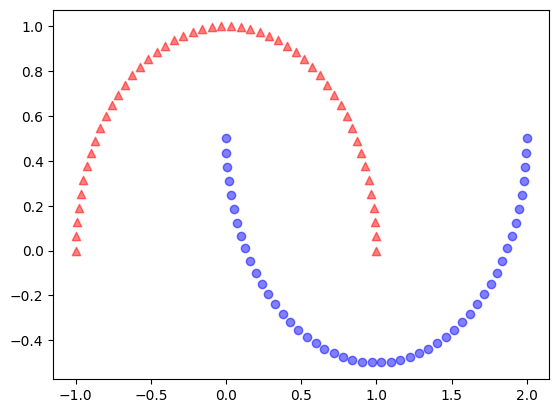

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0,0], X[y==0,1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1,0], X[y==1,1], color='blue', marker='o', alpha=0.5)
plt.show()

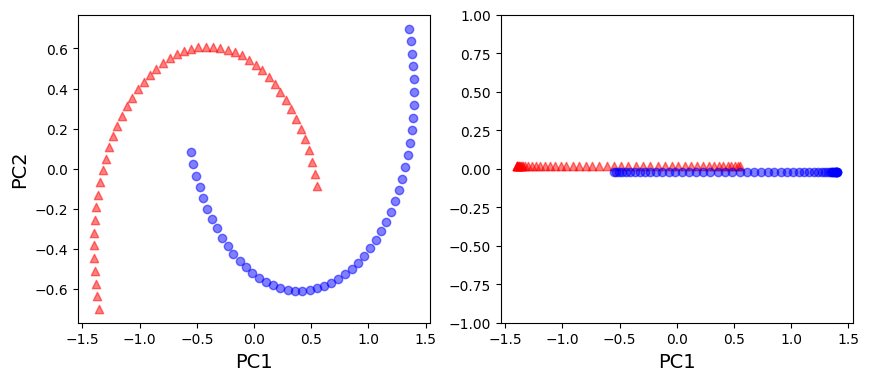

In [ ]:
from sklearn.decomposition import PCA

# It is not necessary to standardize because the axes have similar ranges but it is a good practice to do so
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].scatter(X_pca[y==0,0], X_pca[y==0,1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_pca[y==1,0], X_pca[y==1,1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_pca[y==0,0], np.zeros((50,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_pca[y==1,0], np.zeros((50,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_ylabel('PC2')
ax[0].set_xlabel('PC1')
ax[1].set_xlabel('PC1')
ax[1].set_ylim((-1,1))
plt.show()

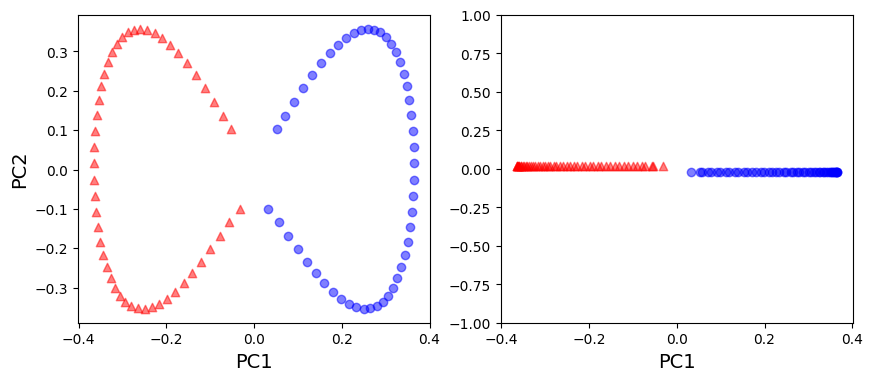

In [ ]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].scatter(X_kpca[y==0,0], X_kpca[y==0,1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1,0], X_kpca[y==1,1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0,0], np.zeros((50,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1,0], np.zeros((50,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_ylabel('PC2')
ax[0].set_xlabel('PC1')
ax[1].set_xlabel('PC1')
ax[1].set_ylim((-1,1))
plt.show()

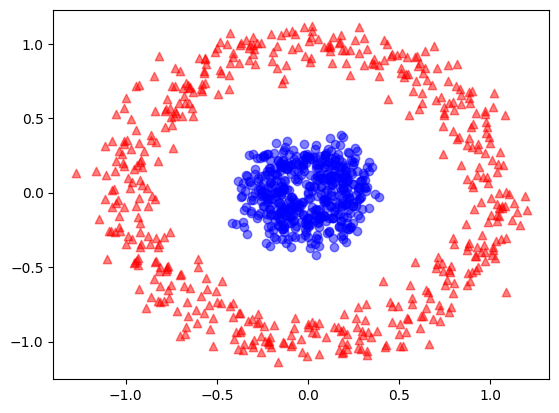

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0,0], X[y==0,1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1,0], X[y==1,1], color='blue', marker='o', alpha=0.5)
plt.show()

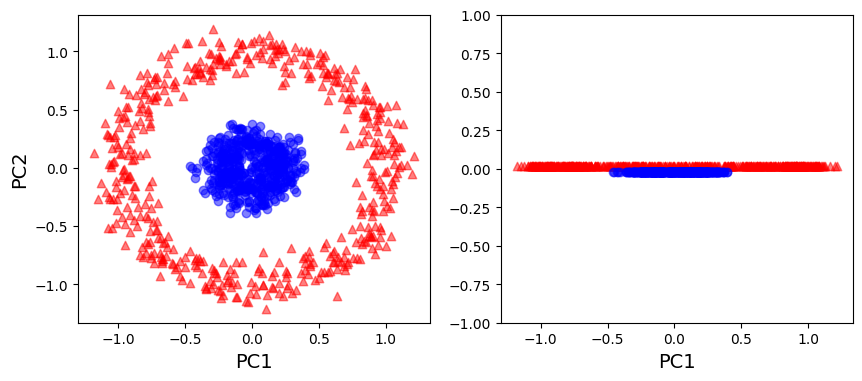

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].scatter(X_pca[y==0,0], X_pca[y==0,1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_pca[y==1,0], X_pca[y==1,1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_pca[y==0,0], np.zeros((500,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_pca[y==1,0], np.zeros((500,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_ylabel('PC2')
ax[0].set_xlabel('PC1')
ax[1].set_xlabel('PC1')
ax[1].set_ylim((-1,1))
plt.show()

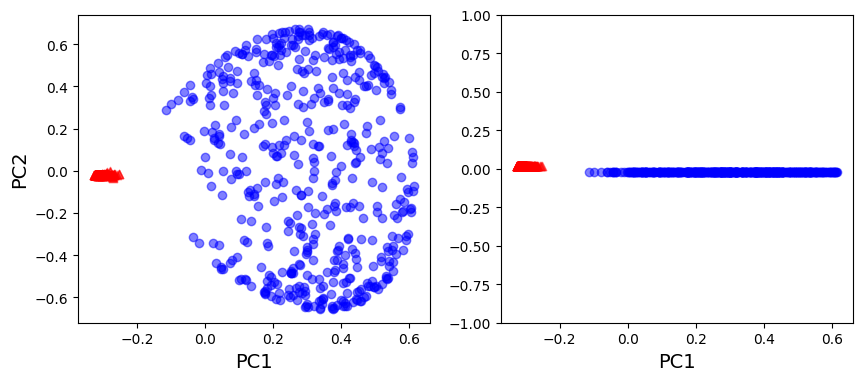

In [ ]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].scatter(X_kpca[y==0,0], X_kpca[y==0,1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1,0], X_kpca[y==1,1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0,0], np.zeros((500,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1,0], np.zeros((500,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_ylabel('PC2')
ax[0].set_xlabel('PC1')
ax[1].set_xlabel('PC1')
ax[1].set_ylim((-1,1))
plt.show()

#### **For Further Exploration**

Check out these resources to deepen your understanding of dimensionality reduction and related concepts:

* [PCA Main ideas](https://youtu.be/HMOI_lkzW08?si=k0p9T87KbCGE9gY9)
* [PCA Explained Step by Step](https://youtu.be/FgakZw6K1QQ?si=QF9C9dJ_kq5jOrav)
* [PCA Practical Tips](https://youtu.be/oRvgq966yZg?si=HzhkYz5ZU8Duvn4n)
* [PCA Visually explained](https://youtu.be/FD4DeN81ODY?si=uCKSTjfd5WeuerE9)
* [LDA Explained](https://youtu.be/azXCzI57Yfc?si=_WjfDfjGOjF_d-Te)
* [The Kernel Trick](https://youtu.be/N_RQj4OL1mg?si=ADc6IEaPT1iHgDyv)

---
**References:**

Disclaimer: Some of the material in this notebook is adapted from other sources. These references are provided for further reading and to acknowledge the original authors.

* Chapter 7 Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurélien Géron, [3rd edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)